In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
#import pyfits
import healpy as hp

In [2]:
def pt_src_mask(map_inp, beam_FWHM, src_cat, flux_cut, disc_FWHM=3.):
    MASK_VAL = -1.e30 #placeholder value for pixels getting masked (feel free to re-define but may want to be consistent with convention in diff_inpaint)
    Npix=len(map_inp) #determine map parameters
    Nside=hp.pixelfunc.npix2nside(Npix) #will raise exception if Npix is not valid
    map_out = np.copy(map_inp) #initialize
    #find all sources above the flux cut and locate their pixels
    cut_cond = np.where(src_cat[:,2] > flux_cut)
    all_cond = cut_cond #can impose other cuts here if desired, e.g., via all_cond = reduce(np.intersect1d, (cut_cond[0],cut_cond2[0],cut_cond3[0]))
    # select
    src_select = src_cat[all_cond]
    N_src_select = len(src_select)
    src_select_RA = src_select[:,0] #in deg
    src_select_Dec = src_select[:,1] #in deg
    # find pixels
    src_select_phi = src_select_RA * np.pi/180.0
    src_select_theta = (90.0 - src_select_Dec) * np.pi/180.0
    #src_select_pix = hp.pixelfunc.ang2pix(Nside, src_select_theta, src_select_phi, nest=False)
    # get all pixels within a disc of radius disc_FWHM*FWHM centered on each of the source pixels
    src_select_vec = hp.pixelfunc.ang2vec(src_select_theta, src_select_phi)
    disc_rad = disc_FWHM*beam_FWHM*(1./60.)*(np.pi/180.) #convert to rad
    for i in range(N_src_select): #is it possible to do this without a for loop here? No, because hp.query_disc can only be run for a single vec location at a time (I tried using an array)
        mask_pix = hp.query_disc(Nside, src_select_vec[i], disc_rad, inclusive=True, fact=2) #inclusive = return pixels that *overlap* with this disk (i.e., more conservative)
        map_out[mask_pix] = MASK_VAL #use an extreme value, but not the same as healpix's UNSEEN value
    return map_out
##############################


##############################
# map_inp = healpix input map [RING-ordered] -- all masked pixels should contain MASK_VAL value
# returns healpix output map -- identical to input map, but with all previously masked pixels now diffusively inpainted
def diff_inpaint(map_inp, MASK_VAL=-1.e30):
    #MASK_VAL = -1.e30 #placeholder value for pixels getting masked (feel free to re-define but may want to be consistent with convention in pt_src_mask above)
    INPAINTED_VAL = -2 #placeholder pixel number to keep in arrays for pixels that have been inpainted
    N_nabes_req = 4 #minimum number of unmasked neighbor pixels required to inpaint a given pixel -- N.B. cannot use value greater than 4 here! (for disk-shaped masks, at least)
    iter_cutoff = 100000 #safety escape to avoid infinite loop if convergence isn't being achieved
    Npix=len(map_inp) #determine map parameters
    Nside=hp.pixelfunc.npix2nside(Npix) #will raise exception if Npix is not valid
    map_out = np.copy(map_inp) #initialize
    map_new = np.zeros(Npix) #initialize map to store the temporary results of the inpainting in each diffusive iteration
    mask_pix = (np.where(map_inp == MASK_VAL))[0] #get masked pixel locations
    # diffusively inpaint: the code finds all pixels on the "edge" of the masked region and inpaints those using the surrounding ones; then iterates inward to completion
    iteration=0
    t1=time.time()
    while (len(mask_pix) > 0):
        print (iteration,len(mask_pix),time.time()-t1,flush=True)
        t1=time.time()
        # 1) get all the neighbor pixels -- n.b. some values returned here could be -1 (if that neighbor doesn't exist)
        nabes = hp.pixelfunc.get_all_neighbours(Nside, mask_pix)
        minn= np.min(nabes)  # fiona edit
        if minn>-1:
            for j in range(len(mask_pix)):
            # 2) see if all the neighbors are masked; if so, skip; if not, take average of the unmasked pixels and assign it to this pixel (AFTER finding all pixels satisfying the criterion)
            #nabes_temp = (nabes[:,j])[np.where(nabes[:,j] != -1)] #get rid of annoying -1 possibilities
            #if (np.any( map_out[nabes_temp] != MASK_VAL )):
                if (len(map_out[nabes[:,j][np.where(map_out[nabes[:,j]] != MASK_VAL)]]) >= N_nabes_req): #rephrase -- can now require >1 neighbor pixel to be unmasked
                    map_new[mask_pix[j]] = np.mean(map_out[nabes[:,j][np.where(map_out[nabes[:,j]] != MASK_VAL)]])
                    mask_pix[j] = INPAINTED_VAL

        else:

            for j in range(len(mask_pix)):
                # 2) see if all the neighbors are masked; if so, skip; if not, take average of the unmasked pixels and assign it to this pixel (AFTER finding all pixels satisfying the criterion)
                nabes_temp = (nabes[:,j])[np.where(nabes[:,j] != -1)] #get rid of annoying -1 possibilities
                #if (np.any( map_out[nabes_temp] != MASK_VAL )):
                if (len(map_out[nabes_temp[np.where(map_out[nabes_temp] != MASK_VAL)]]) >= N_nabes_req): #rephrase -- can now require >1 neighbor pixel to be unmasked
                    map_new[mask_pix[j]] = np.mean(map_out[nabes_temp[np.where(map_out[nabes_temp] != MASK_VAL)]])
                    mask_pix[j] = INPAINTED_VAL
        # 3) remove the inpainted pixels from mask_pix array for next iteration, and assign their values from map_new to map_out (and re-initialize map_new to zeros)
        mask_pix = mask_pix[np.where(mask_pix != INPAINTED_VAL)]
        map_out[np.where(map_new != 0.)] = map_new[np.where(map_new != 0.)]
        map_new = np.zeros(Npix)
        #old testing snippet
        #hp.gnomview(map_out, unit='K', rot=(0.067000001668930054, -0.05899810791015625), coord='G', title='30 GHz ', xsize=400, ysize=400, min=0.0016, max=0.01)
        #plt.savefig('30_GHz_src0_test_masked_inpainted_iter'+str(iteration)+'.png')
        iteration += 1
        if (iteration > iter_cutoff): #safety escape to avoid infinite loop
            print ("diffusive inpainting exceeded "+str(iter_cutoff)+" steps!",flush=True)
            quit()
    return map_out
##############################

def diff_inpaint_vectorized(map_inp, MASK_VAL=-1.e30,N_nabes_req=4):
    #MASK_VAL = -1.e30 #placeholder value for pixels getting masked (feel free to re-define but may want to be consistent with convention in pt_src_mask above)
    INPAINTED_VAL = -2 #placeholder pixel number to keep in arrays for pixels that have been inpainted
    N_nabes_req = N_nabes_req#minimum number of unmasked neighbor pixels required to inpaint a given pixel -- N.B. cannot use value greater than 4 here! (for disk-shaped masks, at least)
    iter_cutoff = 100000 #safety escape to avoid infinite loop if convergence isn't being achieved
    Npix = len(map_inp) #determine map parameters
    Nside = hp.pixelfunc.npix2nside(Npix) #will raise exception if Npix is not valid
    map_out = np.copy(map_inp) #initialize
    map_new = np.zeros(Npix) #initialize map to store the temporary results of the inpainting in each diffusive iteration

    mask_pix = (np.where(map_inp == MASK_VAL))[0] #get masked pixel locations
    # diffusively inpaint: the code finds all pixels on the "edge" of the masked region and inpaints those using the surrounding ones; then iterates inward to completion
    iteration=0
    while (len(mask_pix) > 0):

        print (iteration,len(mask_pix),)
        # 1) get all the neighbor pixels -- n.b. some values returned here could be -1 (if that neighbor doesn't exist)
        nabes = hp.pixelfunc.get_all_neighbours(Nside, mask_pix)

        cutmask = map_out[nabes]  # This is an 8 x Npix dim array with all the 8 neighbours of every pixel

        cutmask[cutmask!=MASK_VAL]=1 #  Include the unmasked pixels

        cutmask[cutmask==MASK_VAL]=0  # Remove the masked pixels

        cutmask = np.sum(cutmask,axis=0)  # Counts the number of unmasked neighbours of each pixel
      
        cutmask2=(cutmask==cutmask) # A boolean mask that we will use to exclude the pixels with < N_nabes_req unmasked neighbours
        cutmask2[cutmask>=N_nabes_req] = True
        cutmask2[cutmask<N_nabes_req] = False
        cutmask=cutmask2.copy()

        del(cutmask2)   # Free up memory

        # A mask that we will use when we take the mean of the unmasked neighbours, to exclude the masked neighbours
        mapoutmask = np.zeros(map_out[nabes].shape)  
        mapoutmask[map_out[nabes]!=MASK_VAL]=True
        mapoutmask[map_out[nabes]==MASK_VAL]=False

        mask_of_nabes = np.zeros(nabes.shape)
        mask_of_nabes[nabes==-1]=False   #Exclude the pixels where -1 was returned above
        mask_of_nabes[nabes!=-1]=True

        mapoutmask = mapoutmask *mask_of_nabes # Final mask of which are the neighbours that we should be taking the mean of


        # now we explicitly take the mean of the NNs at each pixel. the final array will be the new inpainted values
        mean_of_nns = np.sum((map_out[nabes])*mapoutmask,axis=0)[cutmask]/np.sum(mapoutmask,axis=0)[cutmask]

        nm = map_new[mask_pix].copy() # an array with all of the masked pixels

        nm[cutmask] = mean_of_nns  # replace the masked pixels which have the correct properties (unmasked NNs>N_nabes_req) with the means we calculated
        map_new[mask_pix]=nm.copy() # Put these values into the map we use to store things

        mask_pix[cutmask] = INPAINTED_VAL

        mask_pix = mask_pix[np.where(mask_pix != INPAINTED_VAL)]
        map_out[np.where(map_new != 0.)] = map_new[np.where(map_new != 0.)]  # put in the means into the original map
        map_new = np.zeros(Npix)

        iteration += 1
        if (iteration > iter_cutoff): #safety escape to avoid infinite loop
            print ("diffusive inpainting exceeded "+str(iter_cutoff)+" steps!",flush=True)
            quit()
    return map_out
####################



In [4]:
file_for_mask = '/home/yunan/planck_release/planck_mask_512.fits' # fill in filename with a mask defining the region you want to inpaint (regions where the mask is zero will be inpainted in the map)
file_for_map =  '/home/yunan/pyilc/output/IQU_512_1450_test/512_mask/0/CN_needletILCmap_component_CMB.fits'# fill in filename where the map you want to inpaint is stored 
new_inpainted_map_filename = '/home/yunan/impanted_cmb.fits' # fill in filename where you want to save the new inpainted mask
MASK_VAL = -1.e30

if __name__ == "__main__":

    mask = hp.fitsfunc.read_map(file_for_mask)

    map_to_inpaint  = hp.fitsfunc.read_map(file_for_map)
    map_to_inpaint = hp.remove_monopole(map_to_inpaint)

    map_raw = map_to_inpaint.copy()

    map_raw[np.where(mask == 0.)] = MASK_VAL
    inpainted = diff_inpaint_vectorized(map_raw, MASK_VAL=MASK_VAL, N_nabes_req = 1 )

    hp.fitsfunc.write_map(new_inpainted_map_filename,inpainted)

0 677092
1 663545
2 651114
3 639041
4 627174
5 615536
6 604150
7 592981
8 582041
9 571317
10 560777
11 550362
12 540042
13 529810
14 519695
15 509676
16 499763
17 489955
18 480244
19 470626
20 461087
21 451670
22 442349
23 433160
24 424051
25 415044
26 406173
27 397342
28 388545
29 379780
30 371033
31 362291
32 353555
33 344825
34 336102
35 327390
36 318742
37 310163
38 301626
39 293127
40 284691
41 276283
42 267897
43 259533
44 251188
45 242866
46 234567
47 226288
48 218030
49 209834
50 201686
51 193581
52 185514
53 177516
54 169669
55 161972
56 154444
57 147285
58 140608
59 134195
60 128055
61 122107
62 116291
63 110577
64 104949
65 99397
66 93956
67 88627
68 83390
69 78284
70 73396
71 68658
72 64158
73 59873
74 55798
75 51935
76 48254
77 44750
78 41422
79 38253
80 35286
81 32548
82 29996
83 27592
84 25351
85 23261
86 21311
87 19546
88 17878
89 16299
90 14807
91 13424
92 12172
93 11058
94 10054
95 9195
96 8416
97 7694
98 7011
99 6368
100 5765
101 5226
102 4723
103 4246
104 3797
105 3

setting the output map dtype to [dtype('>f8')]


120 76
121 34
122 9


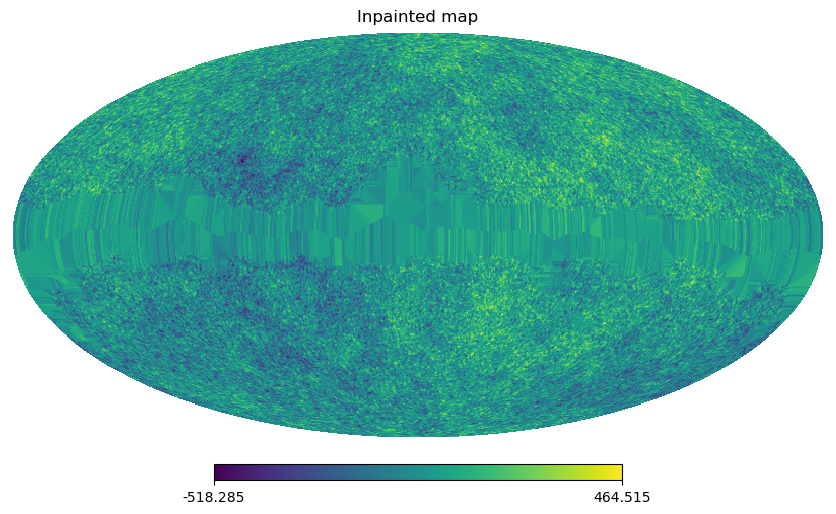

In [5]:
hp.mollview(inpainted, title='Inpainted map')